<a href="https://colab.research.google.com/github/NabilBADRI/Combining-FastText-and-Glove-Word-Embedding-for-Offensive-and-Hate-speech-Text-Detection/blob/main/NLP_ML_Hate_Speech.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive/' )

Mounted at /content/drive/


In [ ]:
from sklearn import model_selection, preprocessing, linear_model, naive_bayes, metrics, svm
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn import decomposition, ensemble
import numpy as np
import xgboost, numpy, textblob, string
from keras.preprocessing import text, sequence
from keras import layers, models, optimizers
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
import seaborn as sn
#------------------------------------------------
import warnings
warnings.filterwarnings('ignore')

In [ ]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [ ]:
df = pd.read_csv("/content/drive/MyDrive/kaggle-nabil-badri/dataset-hatespeech+rumor/hatespeech_text_label_vote - hatespeech_text_label_vote.csv")

In [ ]:
df.drop('Unnamed: 2',axis = 1, inplace=True)

In [ ]:
df.head()

,text,label
0,Beats by Dr. Dre urBeats Wired In-Ear Headphon...,spam
1,RT @Papapishu: Man it would fucking rule if we...,abusive
2,It is time to draw close to Him &#128591;&#127...,normal
3,if you notice me start to act different or dis...,normal
4,"Forget unfollowers, I believe in growing. 7 ne...",normal


Train test split

In [ ]:
x_train,x_test,y_train,y_test = train_test_split(df[['text']], df.label, test_size = 0.2, random_state = 42)

In [ ]:
print('training on    : ' ,len(x_train))
print('validating on  : ' ,len(x_test))
# label encode the target variable 
encoder = preprocessing.LabelEncoder()
y_train = encoder.fit_transform(y_train)
y_test = encoder.transform(y_test)

training on    :  79996
validating on  :  20000


In [ ]:
count_vect = CountVectorizer(analyzer='word', token_pattern=r'\w{1,}')
count_vect.fit(x_train)
 
# transform the training and validation data using count vectorizer object
xtrain_count =  count_vect.transform(x_train.text)
xvalid_count =  count_vect.transform(x_test.text)

In [ ]:
tfidf_vect = TfidfVectorizer(analyzer='word', token_pattern=r'\w{1,}', max_features=5000)
tfidf_vect.fit(x_train.text)
xtrain_tfidf =  tfidf_vect.transform(x_train.text)
xvalid_tfidf =  tfidf_vect.transform(x_test.text)
 
# ngram level tf-idf 
tfidf_vect_ngram = TfidfVectorizer(analyzer='word', token_pattern=r'\w{1,}', ngram_range=(2,3), max_features=5000)
tfidf_vect_ngram.fit(x_train.text)
xtrain_tfidf_ngram =  tfidf_vect_ngram.transform(x_train.text)
xvalid_tfidf_ngram =  tfidf_vect_ngram.transform(x_test.text)
 
# characters level tf-idf
tfidf_vect_ngram_chars = TfidfVectorizer(analyzer='char', token_pattern=r'\w{1,}', ngram_range=(2,3), max_features=5000)
tfidf_vect_ngram_chars.fit(x_train.text)
xtrain_tfidf_ngram_chars =  tfidf_vect_ngram_chars.transform(x_train.text) 
xvalid_tfidf_ngram_chars =  tfidf_vect_ngram_chars.transform(x_test.text)

In [ ]:
nltk.download('averaged_perceptron_tagger')
pos_family = {
    'noun' : ['NN','NNS','NNP','NNPS'],
    'pron' : ['PRP','PRP$','WP','WP$'],
    'verb' : ['VB','VBD','VBG','VBN','VBP','VBZ'],
    'adj' :  ['JJ','JJR','JJS'],
    'adv' : ['RB','RBR','RBS','WRB']
}
 

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


In [ ]:
# function to check and get the part of speech tag count of a words in a given sentence
def check_pos_tag(x, flag):
    cnt = 0
    try:
        wiki = textblob.TextBlob(x)
        for tup in wiki.tags:
            ppo = list(tup)[1]
            if ppo in pos_family[flag]:
                cnt += 1
    except:
        pass
    return cnt
x_train['noun_count'] = x_train['text'].apply(lambda x: check_pos_tag(x, 'noun'))
x_train['verb_count'] = x_train['text'].apply(lambda x: check_pos_tag(x, 'verb'))
x_train['adj_count'] = x_train['text'].apply(lambda x: check_pos_tag(x, 'adj'))
x_train['adv_count'] = x_train['text'].apply(lambda x: check_pos_tag(x, 'adv'))
x_train['pron_count'] = x_train['text'].apply(lambda x: check_pos_tag(x, 'pron'))

In [ ]:
x_train.head()

,text,noun_count,verb_count,adj_count,adv_count,pron_count
92723,RT @paytons_hawtmom: I knew that girl was fuck...,7,3,0,0,1
37683,RT @SheaSerrano: SHE FUCKING DID IT!!!!!!!!!!!...,7,0,0,0,0
38241,What happened with all the people concerned ab...,7,4,2,0,1
3806,When you are ready to make excuses and give up...,6,4,1,1,1
65306,@garyashley5 @sommecourt This is a much better...,7,2,1,3,0


In [ ]:
# train a LDA Model
lda_model = decomposition.LatentDirichletAllocation(n_components=20, learning_method='online', max_iter=20)
X_topics = lda_model.fit_transform(xtrain_count)
topic_word = lda_model.components_ 
vocab = count_vect.get_feature_names()
 
# view the topic models
n_top_words = 10
topic_summaries = []
for i, topic_dist in enumerate(topic_word):
    topic_words = numpy.array(vocab)[numpy.argsort(topic_dist)][:-(n_top_words+1):-1]
    topic_summaries.append(' '.join(topic_words))

In [ ]:
df.label.unique()

array(['spam', 'abusive', 'normal', 'hateful'], dtype=object)

In [ ]:
encoder.classes_

array(['abusive', 'hateful', 'normal', 'spam'], dtype=object)

In [ ]:
def train_model(classifier, feature_vector_train, label, feature_vector_valid, is_neural_net=False):
    # fit the training dataset on the classifier
    classifier.fit(feature_vector_train, label)
    # predict the labels on validation dataset
    predictions = classifier.predict(feature_vector_valid)
    
    if is_neural_net:
        predictions = predictions.argmax(axis=1)
        classification_rep = classification_report(y_test,predictions, target_names=(['spam', 'abusive', 'normal', 'hateful']))
    else :
      classification_rep = classification_report(y_test,predictions, target_names=(['abusive', 'hateful', 'normal', 'spam']))
    return (metrics.accuracy_score(y_test, predictions), metrics.f1_score(y_test, predictions, average='weighted'), 
            metrics.recall_score(y_test, predictions,average='weighted'), metrics.precision_score(y_test, predictions,average='weighted'),
            metrics.confusion_matrix(y_test, predictions), classification_rep)


In [ ]:
def result_vis(result):
  width = 0.5
  labels = list(result.keys())
  accuracy = []
  f1_score = []
  recall = []
  precision = []
  for label in labels :
    print("[INFO] Metrics for : ", label)
    print("Accuracy_______:  ",result[label]['accuracy'])
    print("F1_score_______:  ",result[label]['f1_score'])
    print("Recall_________:  ",result[label]['recall'])
    print("Precision______:  ",result[label]['precision'])
    print("classification report :")
    print(result[label]['report'])
    df_cm = pd.DataFrame(result[label]["confusion_matrix"], range(4), range(4))
    sn.set(font_scale=1.4) # for label size
    sn.heatmap(df_cm, annot=True, annot_kws={"size": 16}, fmt="d", xticklabels=['spam', 'abusive', 'normal', 'hateful'],
               yticklabels=['spam', 'abusive', 'normal', 'hateful']) # font size
    plt.show()


    accuracy.append(result[label]['accuracy'])
    f1_score.append(result[label]['f1_score'])
    recall.append(result[label]['recall'])
    precision.append(result[label]['precision'])
  X = np.arange(len(labels))
  fig = plt.figure()
  fig.set_size_inches(8,5)
  ax = fig.add_axes([0,0,1,1])
  rect1 = ax.bar(X + 0.00,accuracy, color = 'b', width = 0.20)
  rect2 = ax.bar(X + 0.20, f1_score, color = 'g', width = 0.20)
  rect3 = ax.bar(X + 0.40, recall , color = 'r', width = 0.20)
  rect4 = ax.bar(X + 0.60, precision , color = (1, 0, 1), width = 0.20)

  ax.set_ylabel('Scores')
  ax.set_title('metrics')
  ax.set_xlabel(labels)
  def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

  autolabel(rect1)
  autolabel(rect2)
  autolabel(rect3)
  autolabel(rect4)
  ax.set_xticks([r + 0.25 / 2 for r in range(len(labels))],labels)
  ax.legend(labels=['accuracy', 'f1_score', 'recall', 'precision'],loc='best')
  plt.ylim(0, 1)


In [ ]:
from sklearn.model_selection import GridSearchCV


In [ ]:
xtrain_count.shape

(79996, 1)

NB, WordLevel TF-IDF:  (0.771, 0.7453092551986207, 0.771, 0.7660864521850042, array([[4400,   11,  902,   56],
       [ 476,   61,  424,    5],
       [ 442,    2, 9861,  543],
       [ 137,    0, 1582, 1098]]), '              precision    recall  f1-score   support\n\n     abusive       0.81      0.82      0.81      5369\n     hateful       0.82      0.06      0.12       966\n      normal       0.77      0.91      0.84     10848\n        spam       0.65      0.39      0.49      2817\n\n    accuracy                           0.77     20000\n   macro avg       0.76      0.55      0.56     20000\nweighted avg       0.77      0.77      0.75     20000\n')
NB, N-Gram Vectors:  (0.71825, 0.6897526937714531, 0.71825, 0.7119183028514606, array([[3543,   45, 1691,   90],
       [ 304,  100,  557,    5],
       [ 370,    9, 9918,  551],
       [  91,    1, 1921,  804]]), '              precision    recall  f1-score   support\n\n     abusive       0.82      0.66      0.73      5369\n     hateful 

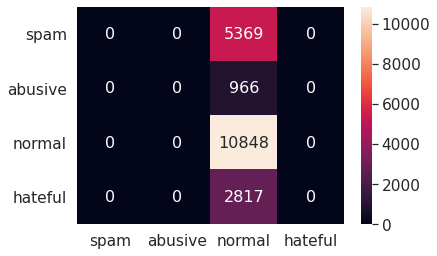

[INFO] Metrics for :  navie_bayes_TF-IDF
Accuracy_______:   0.77
F1_score_______:   0.75
Recall_________:   0.77
Precision______:   0.77
classification report :
              precision    recall  f1-score   support

     abusive       0.81      0.82      0.81      5369
     hateful       0.82      0.06      0.12       966
      normal       0.77      0.91      0.84     10848
        spam       0.65      0.39      0.49      2817

    accuracy                           0.77     20000
   macro avg       0.76      0.55      0.56     20000
weighted avg       0.77      0.77      0.75     20000



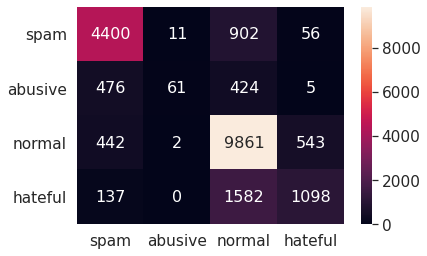

[INFO] Metrics for :  navie_bayes_N-Gram_Vectors
Accuracy_______:   0.72
F1_score_______:   0.69
Recall_________:   0.72
Precision______:   0.71
classification report :
              precision    recall  f1-score   support

     abusive       0.82      0.66      0.73      5369
     hateful       0.65      0.10      0.18       966
      normal       0.70      0.91      0.80     10848
        spam       0.55      0.29      0.38      2817

    accuracy                           0.72     20000
   macro avg       0.68      0.49      0.52     20000
weighted avg       0.71      0.72      0.69     20000



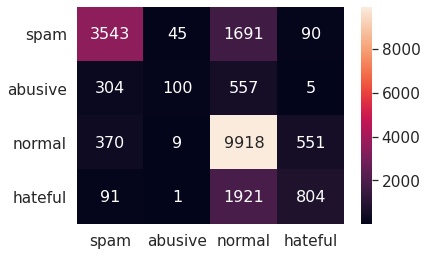

[INFO] Metrics for :  navie_bayes_CharLevel Vectors
Accuracy_______:   0.74
F1_score_______:   0.72
Recall_________:   0.74
Precision______:   0.74
classification report :
              precision    recall  f1-score   support

     abusive       0.80      0.76      0.78      5369
     hateful       0.81      0.10      0.18       966
      normal       0.75      0.86      0.80     10848
        spam       0.53      0.46      0.49      2817

    accuracy                           0.74     20000
   macro avg       0.72      0.54      0.56     20000
weighted avg       0.74      0.74      0.72     20000



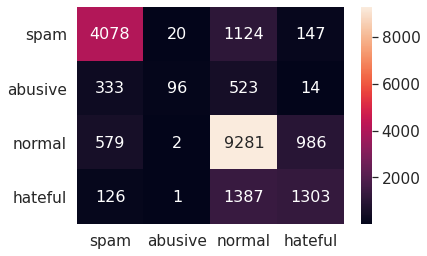

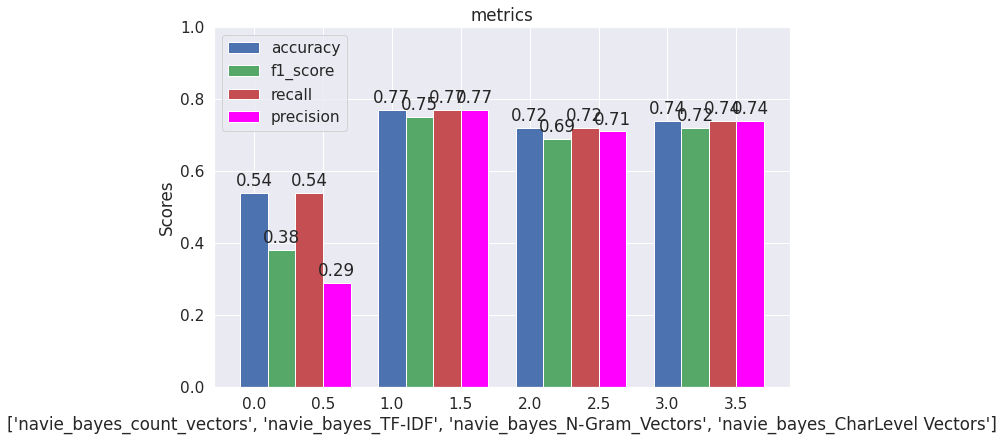

In [ ]:
# Naive Bayes on Count Vectors
result = {}
metric = train_model(naive_bayes.MultinomialNB(alpha=1.0), xtrain_count, y_train, xvalid_count )
# Naive Bayes on Word Level TF IDF Vectors
result["navie_bayes_count_vectors"] = {"accuracy":round(metric[0],2),"f1_score":round(metric[1],2),"recall":round(metric[2],2),
                                       "precision":round(metric[3], 2), "confusion_matrix":metric[4], "report": metric[5]}
metric = train_model(naive_bayes.MultinomialNB(alpha=1.0), xtrain_tfidf, y_train, xvalid_tfidf)
print ("NB, WordLevel TF-IDF: ", metric)
result["navie_bayes_TF-IDF"] = {"accuracy":round(metric[0],2),"f1_score":round(metric[1],2),"recall":round(metric[2],2),
                                "precision":round(metric[3], 2), "confusion_matrix":metric[4], "report": metric[5]}
# Naive Bayes on Ngram Level TF IDF Vectors
metric = train_model(naive_bayes.MultinomialNB(alpha=1.0), xtrain_tfidf_ngram, y_train, xvalid_tfidf_ngram)
print ("NB, N-Gram Vectors: ", metric)
result["navie_bayes_N-Gram_Vectors"] = {"accuracy":round(metric[0],2),"f1_score":round(metric[1],2),"recall":round(metric[2],2),
                                        "precision":round(metric[3],2), "confusion_matrix":metric[4], "report": metric[5]}

# Naive Bayes on Character Level TF IDF Vectors
metric = train_model(naive_bayes.MultinomialNB(alpha=1.0), xtrain_tfidf_ngram_chars, y_train, xvalid_tfidf_ngram_chars )
print ("NB, CharLevel Vectors: ", metric)
result["navie_bayes_CharLevel Vectors"] = {"accuracy":round(metric[0],2),"f1_score":round(metric[1],2),"recall":round(metric[2],2),
                                           "precision":round(metric[3],2), "confusion_matrix":metric[4], "report": metric[5]}
result_vis(result)


In [ ]:
param={'C': 1.0, 'penalty': 'l1', 'solver': 'liblinear'}

[INFO] Metrics for :  LR, Count Vectors
Accuracy_______:   0.54
F1_score_______:   0.38
Recall_________:   0.54
Precision______:   0.29
classification report :
              precision    recall  f1-score   support

     abusive       0.00      0.00      0.00      5369
     hateful       0.00      0.00      0.00       966
      normal       0.54      1.00      0.70     10848
        spam       0.00      0.00      0.00      2817

    accuracy                           0.54     20000
   macro avg       0.14      0.25      0.18     20000
weighted avg       0.29      0.54      0.38     20000



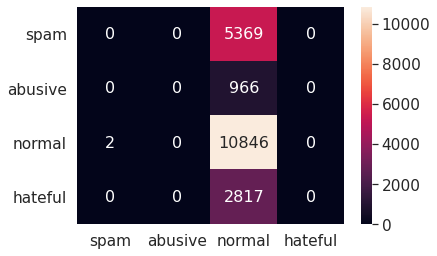

[INFO] Metrics for :  LR, WordLevel TF-IDF
Accuracy_______:   0.81
F1_score_______:   0.79
Recall_________:   0.81
Precision______:   0.8
classification report :
              precision    recall  f1-score   support

     abusive       0.87      0.91      0.89      5369
     hateful       0.68      0.23      0.34       966
      normal       0.81      0.93      0.86     10848
        spam       0.65      0.38      0.48      2817

    accuracy                           0.81     20000
   macro avg       0.75      0.61      0.64     20000
weighted avg       0.80      0.81      0.79     20000



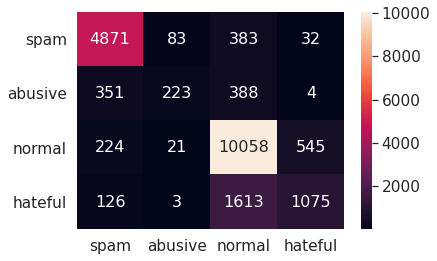

[INFO] Metrics for :  LR, N-Gram Vectors
Accuracy_______:   0.74
F1_score_______:   0.7
Recall_________:   0.74
Precision______:   0.74
classification report :
              precision    recall  f1-score   support

     abusive       0.85      0.70      0.77      5369
     hateful       0.75      0.12      0.21       966
      normal       0.71      0.95      0.81     10848
        spam       0.65      0.21      0.32      2817

    accuracy                           0.74     20000
   macro avg       0.74      0.50      0.53     20000
weighted avg       0.74      0.74      0.70     20000



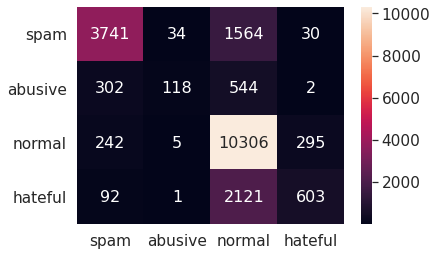

[INFO] Metrics for :  LR, CharLevel Vectors
Accuracy_______:   0.8
F1_score_______:   0.78
Recall_________:   0.8
Precision______:   0.79
classification report :
              precision    recall  f1-score   support

     abusive       0.87      0.89      0.88      5369
     hateful       0.70      0.20      0.31       966
      normal       0.80      0.93      0.86     10848
        spam       0.63      0.36      0.46      2817

    accuracy                           0.80     20000
   macro avg       0.75      0.59      0.63     20000
weighted avg       0.79      0.80      0.78     20000



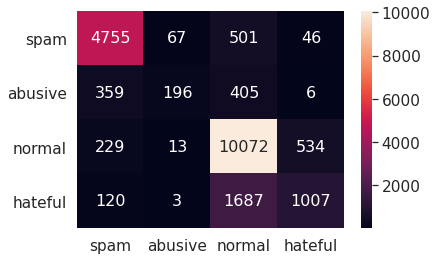

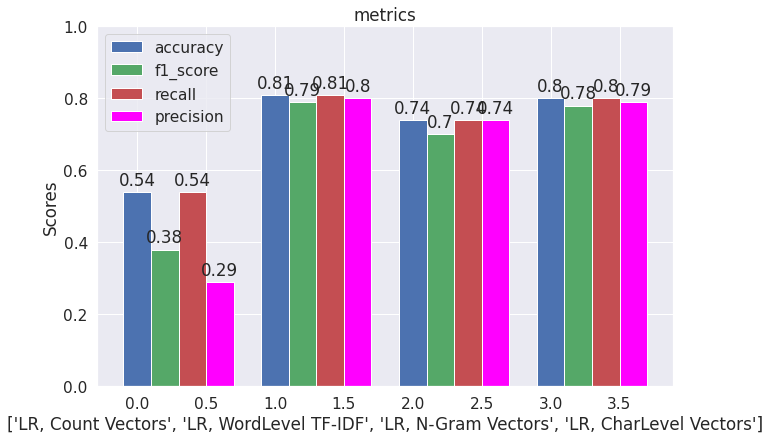

In [ ]:
result.clear()
# Linear Classifier on Count Vectors
metric = train_model(linear_model.LogisticRegression(**param), xtrain_count, y_train, xvalid_count)
result["LR, Count Vectors"] = {"accuracy":round(metric[0],2),"f1_score":round(metric[1],2),"recall":round(metric[2],2),
                               "precision":round(metric[3],2), "confusion_matrix":metric[4], "report": metric[5]}
# Linear Classifier on Word Level TF IDF Vectors
metric = train_model(linear_model.LogisticRegression(**param), xtrain_tfidf, y_train, xvalid_tfidf)

result["LR, WordLevel TF-IDF"] = {"accuracy":round(metric[0],2),"f1_score":round(metric[1],2),"recall":round(metric[2],2),
                                  "precision":round(metric[3],2), "confusion_matrix":metric[4], "report": metric[5]}

# Linear Classifier on Ngram Level TF IDF Vectors
metric = train_model(linear_model.LogisticRegression(**param), xtrain_tfidf_ngram, y_train, xvalid_tfidf_ngram)

result["LR, N-Gram Vectors"] = {"accuracy":round(metric[0],2),"f1_score":round(metric[1],2),"recall":round(metric[2],2),
                                "precision":round(metric[3],2), "confusion_matrix":metric[4], "report": metric[5]}

# Linear Classifier on Character Level TF IDF Vectors
metric = train_model(linear_model.LogisticRegression(**param), xtrain_tfidf_ngram_chars, y_train, xvalid_tfidf_ngram_chars)

result["LR, CharLevel Vectors"] = {"accuracy":round(metric[0],2),"f1_score":round(metric[1],2),"recall":round(metric[2],2),
                                   "precision":round(metric[3],2), "confusion_matrix":metric[4], "report": metric[5]}
result_vis(result)
result.clear()

SVM, N-Gram Vectors:  (0.7376, 0.7024150346568376, 0.7376, 0.7348805203965749, array([[ 3761,    52,  1515,    41],
       [  301,   131,   533,     1],
       [  262,     9, 10257,   320],
       [  100,     1,  2113,   603]]), '              precision    recall  f1-score   support\n\n     abusive       0.85      0.70      0.77      5369\n     hateful       0.68      0.14      0.23       966\n      normal       0.71      0.95      0.81     10848\n        spam       0.62      0.21      0.32      2817\n\n    accuracy                           0.74     20000\n   macro avg       0.72      0.50      0.53     20000\nweighted avg       0.73      0.74      0.70     20000\n')
NB, CharLevel Vectors:  (0.80605, 0.7892872048984428, 0.80605, 0.7917994871372799, array([[4797,   99,  418,   55],
       [ 358,  235,  366,    7],
       [ 251,   20, 9944,  633],
       [ 121,    3, 1548, 1145]]), '              precision    recall  f1-score   support\n\n     abusive       0.87      0.89      0.88     

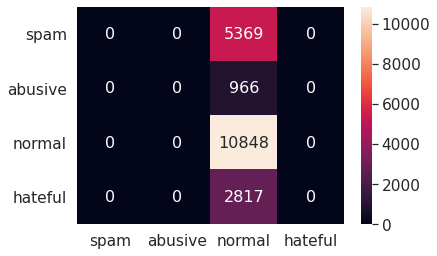

[INFO] Metrics for :  SVM, WordLevel TF-IDF
Accuracy_______:   0.81
F1_score_______:   0.8
Recall_________:   0.81
Precision______:   0.8
classification report :
              precision    recall  f1-score   support

     abusive       0.87      0.91      0.89      5369
     hateful       0.65      0.26      0.37       966
      normal       0.82      0.91      0.86     10848
        spam       0.63      0.45      0.52      2817

    accuracy                           0.81     20000
   macro avg       0.74      0.63      0.66     20000
weighted avg       0.80      0.81      0.80     20000



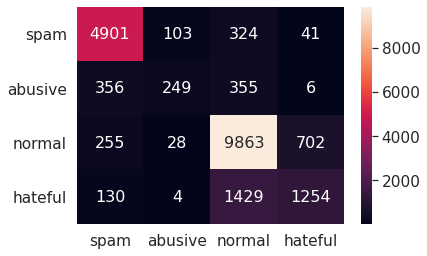

[INFO] Metrics for :  SVM N-Gram_Vectors
Accuracy_______:   0.74
F1_score_______:   0.7
Recall_________:   0.74
Precision______:   0.73
classification report :
              precision    recall  f1-score   support

     abusive       0.85      0.70      0.77      5369
     hateful       0.68      0.14      0.23       966
      normal       0.71      0.95      0.81     10848
        spam       0.62      0.21      0.32      2817

    accuracy                           0.74     20000
   macro avg       0.72      0.50      0.53     20000
weighted avg       0.73      0.74      0.70     20000



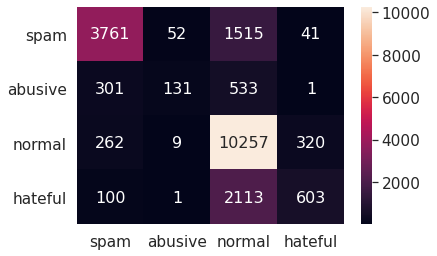

[INFO] Metrics for :  SVM CharLevel Vectors
Accuracy_______:   0.81
F1_score_______:   0.79
Recall_________:   0.81
Precision______:   0.79
classification report :
              precision    recall  f1-score   support

     abusive       0.87      0.89      0.88      5369
     hateful       0.66      0.24      0.36       966
      normal       0.81      0.92      0.86     10848
        spam       0.62      0.41      0.49      2817

    accuracy                           0.81     20000
   macro avg       0.74      0.61      0.65     20000
weighted avg       0.79      0.81      0.79     20000



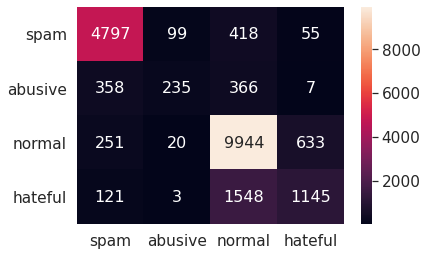

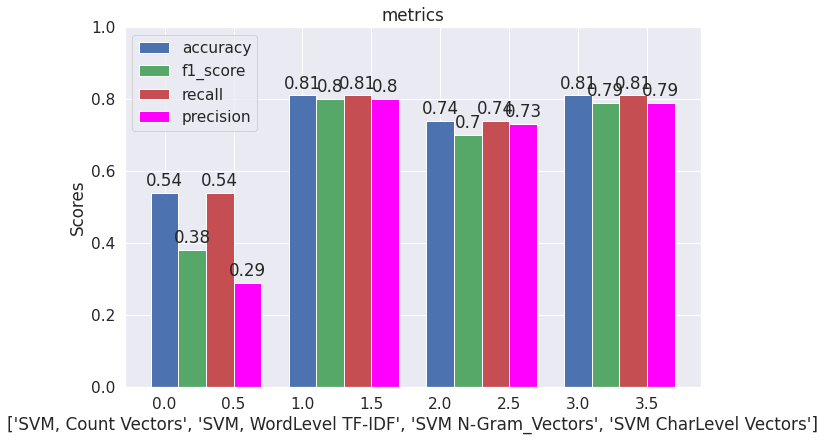

In [ ]:
result = {}
# SVM on Word Level Count Vectors

metric = train_model(svm.SVC(**{'C': 10, 'gamma': 0.1, 'kernel': 'rbf'}), xtrain_count, y_train, xvalid_count)

result["SVM, Count Vectors"] = {"accuracy":round(metric[0],2),"f1_score":round(metric[1],2),"recall":round(metric[2],2),
                               "precision":round(metric[3],2), "confusion_matrix":metric[4], "report": metric[5]}
# SVM on Word Level TF IDF Vectors
metric = train_model(svm.SVC(**{'C': 10, 'gamma': 0.1, 'kernel': 'rbf'}), xtrain_tfidf, y_train, xvalid_tfidf)

result["SVM, WordLevel TF-IDF"] = {"accuracy":round(metric[0],2),"f1_score":round(metric[1],2),"recall":round(metric[2],2),
                                  "precision":round(metric[3],2), "confusion_matrix":metric[4], "report": metric[5]}
                              
# SVM on Ngram Level TF IDF Vectors
metric = train_model(svm.SVC(**{'C': 10, 'gamma': 0.1, 'kernel': 'rbf'}), xtrain_tfidf_ngram, y_train, xvalid_tfidf_ngram)
print ("SVM, N-Gram Vectors: ", metric)
result["SVM N-Gram_Vectors"] = {"accuracy":round(metric[0],2),"f1_score":round(metric[1],2),"recall":round(metric[2],2),
                                        "precision":round(metric[3],2), "confusion_matrix":metric[4], "report": metric[5]}

# SVM on Character Level TF IDF Vectors
metric = train_model(svm.SVC(**{'C': 10, 'gamma': 0.1, 'kernel': 'rbf'}), xtrain_tfidf_ngram_chars, y_train, xvalid_tfidf_ngram_chars )
print ("NB, CharLevel Vectors: ", metric)
result["SVM CharLevel Vectors"] = {"accuracy":round(metric[0],2),"f1_score":round(metric[1],2),"recall":round(metric[2],2),
                                           "precision":round(metric[3],2), "confusion_matrix":metric[4], "report": metric[5]}

result_vis(result)
result.clear()

[INFO] Metrics for :  RF, Count Vectors
Accuracy_______:   0.66
F1_score_______:   0.6
Recall_________:   0.66
Precision______:   0.7
classification report :
              precision    recall  f1-score   support

     abusive       0.88      0.42      0.57      5369
     hateful       0.70      0.10      0.18       966
      normal       0.63      0.98      0.77     10848
        spam       0.63      0.08      0.14      2817

    accuracy                           0.66     20000
   macro avg       0.71      0.40      0.41     20000
weighted avg       0.70      0.66      0.60     20000



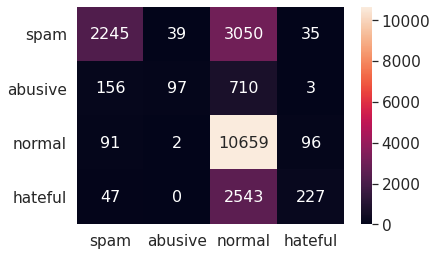

[INFO] Metrics for :  RF, WordLevel TF-IDF
Accuracy_______:   0.66
F1_score_______:   0.6
Recall_________:   0.66
Precision______:   0.7
classification report :
              precision    recall  f1-score   support

     abusive       0.88      0.42      0.57      5369
     hateful       0.70      0.10      0.18       966
      normal       0.63      0.98      0.77     10848
        spam       0.63      0.08      0.14      2817

    accuracy                           0.66     20000
   macro avg       0.71      0.40      0.41     20000
weighted avg       0.70      0.66      0.60     20000



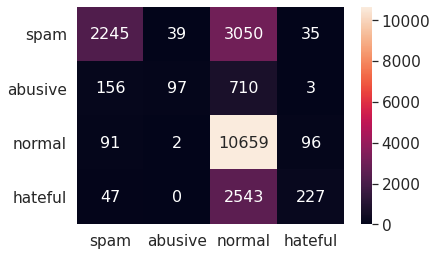

[INFO] Metrics for :  RF, N-Gram Vectors
Accuracy_______:   0.72
F1_score_______:   0.69
Recall_________:   0.72
Precision______:   0.71
classification report :
              precision    recall  f1-score   support

     abusive       0.81      0.71      0.76      5369
     hateful       0.50      0.15      0.23       966
      normal       0.71      0.91      0.80     10848
        spam       0.54      0.23      0.33      2817

    accuracy                           0.72     20000
   macro avg       0.64      0.50      0.53     20000
weighted avg       0.71      0.72      0.69     20000



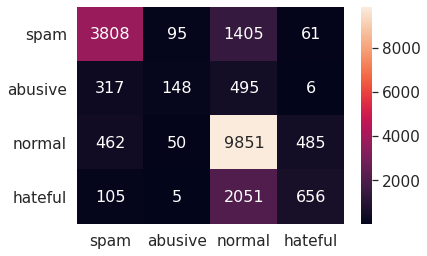

[INFO] Metrics for :  RF, CharLevel Vectors
Accuracy_______:   0.78
F1_score_______:   0.75
Recall_________:   0.78
Precision______:   0.77
classification report :
              precision    recall  f1-score   support

     abusive       0.87      0.86      0.86      5369
     hateful       0.67      0.18      0.29       966
      normal       0.77      0.95      0.85     10848
        spam       0.62      0.23      0.34      2817

    accuracy                           0.78     20000
   macro avg       0.73      0.55      0.58     20000
weighted avg       0.77      0.78      0.75     20000



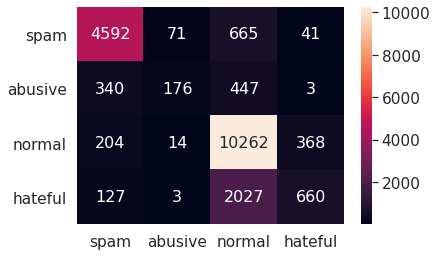

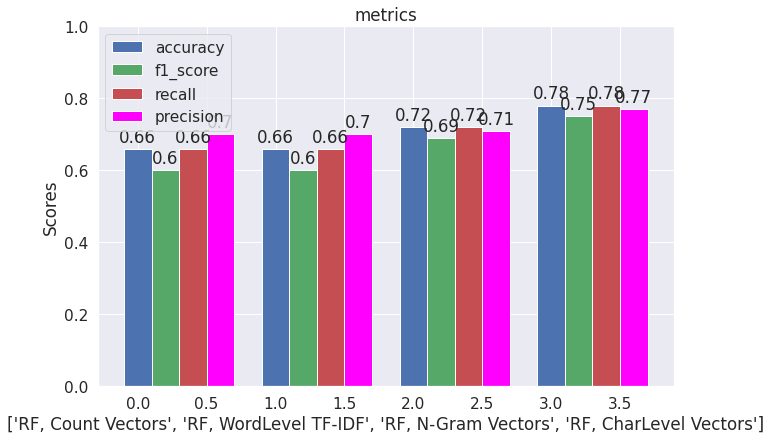

In [ ]:
# RF on Count Vectors
result = {}
accuracy = train_model(ensemble.RandomForestClassifier(), xtrain_count, y_train, xvalid_count)

result["RF, Count Vectors"] = {"accuracy":round(metric[0],2),"f1_score":round(metric[1],2),"recall":round(metric[2],2),
                               "precision":round(metric[3],2), "confusion_matrix":metric[4], "report": metric[5]}
# RF on Word Level TF IDF Vectors
accuracy = train_model(ensemble.RandomForestClassifier(), xtrain_tfidf, y_train, xvalid_tfidf)
result["RF, WordLevel TF-IDF"] = {"accuracy":round(metric[0],2),"f1_score":round(metric[1],2),"recall":round(metric[2],2),
                                  "precision":round(metric[3],2), "confusion_matrix":metric[4], "report": metric[5]}

# RF on Ngram Level TF IDF Vectors
metric = train_model(ensemble.RandomForestClassifier(), xtrain_tfidf_ngram, y_train, xvalid_tfidf_ngram)

result["RF, N-Gram Vectors"] = {"accuracy":round(metric[0],2),"f1_score":round(metric[1],2),"recall":round(metric[2],2),
                                "precision":round(metric[3],2), "confusion_matrix":metric[4], "report": metric[5]}

# RF on Character Level TF IDF Vectors
metric = train_model(ensemble.RandomForestClassifier(), xtrain_tfidf_ngram_chars, y_train, xvalid_tfidf_ngram_chars)

result["RF, CharLevel Vectors"] = {"accuracy":round(metric[0],2),"f1_score":round(metric[1],2),"recall":round(metric[2],2),
                                   "precision":round(metric[3],2), "confusion_matrix":metric[4], "report": metric[5]}

result_vis(result)
result.clear()

In [ ]:
params={'colsample_bytree': 0.8,
 'gamma': 1,
 'max_depth': 4,
 'min_child_weight': 1,
 'subsample': 0.8}

[INFO] Metrics for :  Xgb, Count Vectors
Accuracy_______:   0.54
F1_score_______:   0.38
Recall_________:   0.54
Precision______:   0.29
classification report :
              precision    recall  f1-score   support

     abusive       0.00      0.00      0.00      5369
     hateful       0.00      0.00      0.00       966
      normal       0.54      1.00      0.70     10848
        spam       0.00      0.00      0.00      2817

    accuracy                           0.54     20000
   macro avg       0.14      0.25      0.18     20000
weighted avg       0.29      0.54      0.38     20000



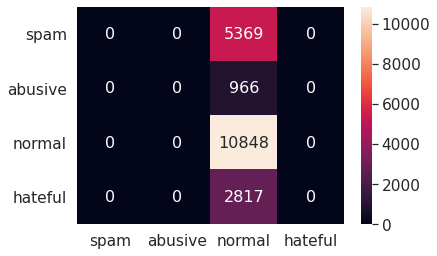

[INFO] Metrics for :  Xgb, WordLevel TF-IDF
Accuracy_______:   0.79
F1_score_______:   0.74
Recall_________:   0.79
Precision______:   0.77
classification report :
              precision    recall  f1-score   support

     abusive       0.86      0.88      0.87      5369
     hateful       0.72      0.21      0.33       966
      normal       0.76      0.96      0.85     10848
        spam       0.66      0.12      0.20      2817

    accuracy                           0.79     20000
   macro avg       0.75      0.54      0.56     20000
weighted avg       0.77      0.79      0.74     20000



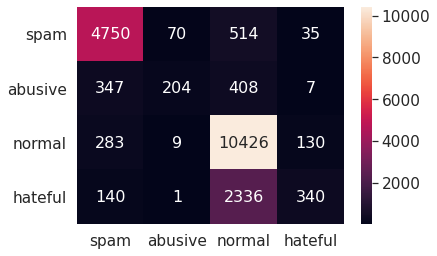

[INFO] Metrics for :  Xgb, CharLevel Vectors
Accuracy_______:   0.8
F1_score_______:   0.77
Recall_________:   0.8
Precision______:   0.79
classification report :
              precision    recall  f1-score   support

     abusive       0.87      0.89      0.88      5369
     hateful       0.73      0.21      0.33       966
      normal       0.78      0.95      0.86     10848
        spam       0.66      0.24      0.36      2817

    accuracy                           0.80     20000
   macro avg       0.76      0.57      0.60     20000
weighted avg       0.79      0.80      0.77     20000



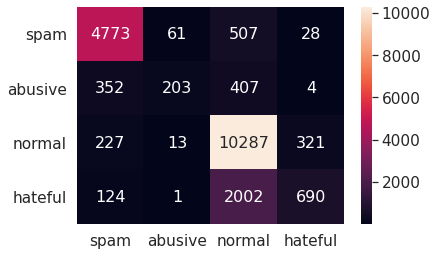

[INFO] Metrics for :  RF, N-Gram Vectors
Accuracy_______:   0.66
F1_score_______:   0.6
Recall_________:   0.66
Precision______:   0.7
classification report :
              precision    recall  f1-score   support

     abusive       0.88      0.42      0.57      5369
     hateful       0.70      0.10      0.18       966
      normal       0.63      0.98      0.77     10848
        spam       0.63      0.08      0.14      2817

    accuracy                           0.66     20000
   macro avg       0.71      0.40      0.41     20000
weighted avg       0.70      0.66      0.60     20000



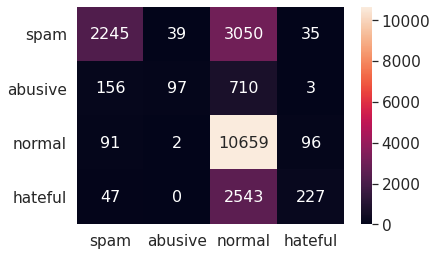

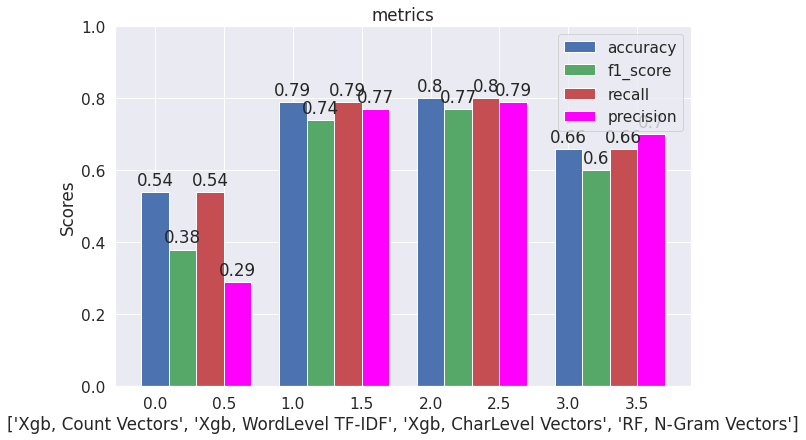

In [ ]:
metric = train_model(xgboost.XGBClassifier(**params), xtrain_count.tocsc(), y_train, xvalid_count.tocsc())
result["Xgb, Count Vectors"] = {"accuracy":round(metric[0],2),"f1_score":round(metric[1],2),"recall":round(metric[2],2),
                                "precision":round(metric[3],2), "confusion_matrix":metric[4], "report": metric[5]}

# Extereme Gradient Boosting on Word Level TF IDF Vectors
metric = train_model(xgboost.XGBClassifier(**params), xtrain_tfidf.tocsc(), y_train, xvalid_tfidf.tocsc())
result["Xgb, WordLevel TF-IDF"] = {"accuracy":round(metric[0],2),"f1_score":round(metric[1],2),"recall":round(metric[2],2),
                                   "precision":round(metric[3],2), "confusion_matrix":metric[4], "report": metric[5]}

# Extereme Gradient Boosting on Character Level TF IDF Vectors
metric = train_model(xgboost.XGBClassifier(**params), xtrain_tfidf_ngram_chars.tocsc(), y_train, xvalid_tfidf_ngram_chars.tocsc())
result["Xgb, CharLevel Vectors"] = {"accuracy":round(metric[0],2),"f1_score":round(metric[1],2),"recall":round(metric[2],2),
                                    "precision":round(metric[3],2), "confusion_matrix":metric[4], "report": metric[5]}

# Extereme Gradient Boosting on Ngram Level TF IDF Vectors
metric = train_model(xgboost.XGBClassifier(**params), xtrain_tfidf_ngram, y_train, xvalid_tfidf_ngram)
result["RF, N-Gram Vectors"] = {"accuracy":round(metric[0],2),"f1_score":round(metric[1],2),"recall":round(metric[2],2),
                                "precision":round(metric[3],2), "confusion_matrix":metric[4], "report": metric[5]}
result_vis(result)
result.clear()